## Benchmark 6 revisit: linear models with structured bootstrap resampling
OK, so first round of linear model submissions to the public leaderboard produced some concerning results. TLDR: control resampling distribution seems to predict public leaderboard result well, linear models do not. Bootstrapping result look as if both Seigel and Theil-Sen regression will beat naive control with high probability, but both receive low scores that are extremely unlikely given their observed bootstrapped score distributions. What's going on? Let's try and find out - first thing is to check every step by manually inspecting output for sanity.

Note: this is version 2 of this notebook, version 1 was preserved in the state which produced the suspect results under investigation for reference.

While we are at it, let's start a major refactor here and move away from using notebooks for our main data generating logic and functions and instead use them just for plotting and discussion.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Results](#results)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="results"></a>
### 2. Results

In [10]:
# Inspect results - each row is an individual datapoint from a sample
data_df = pd.DataFrame(data)
data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,10,0.000000,1.574804e-02,1.730294,1.757759,"[1.727921, 1.810203, 1.7827756, 1.8401538, 1.7...","[0.0, 0.08228199999999997, -0.0274274000000001...",1.730294
1,0,OLS,10,0.019739,7.427632e-03,1.696474,1.717489,"[1.727921, 1.810203, 1.7827756, 1.8401538, 1.7...","[0.0, 0.08228199999999997, -0.0274274000000001...",1.730294
2,0,TS,10,0.040566,0.000000e+00,1.661498,1.730294,"[1.727921, 1.810203, 1.7827756, 1.8401538, 1.7...","[0.0, 0.08228199999999997, -0.0274274000000001...",1.730294
3,0,Seigel,10,0.040854,2.566554e-16,1.661019,1.730294,"[1.727921, 1.810203, 1.7827756, 1.8401538, 1.7...","[0.0, 0.08228199999999997, -0.0274274000000001...",1.730294
4,0,Ridge,10,0.019369,7.336698e-03,1.697101,1.717646,"[1.727921, 1.810203, 1.7827756, 1.8401538, 1.7...","[0.0, 0.08228199999999997, -0.0274274000000001...",1.730294


In [11]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,OLS,10,3.683098,1.838982
1,0,OLS,12,3.372164,1.682958
2,0,OLS,14,3.261159,1.476655
3,0,OLS,16,8.727641,1.280832
4,0,OLS,32,5.771257,0.944460


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

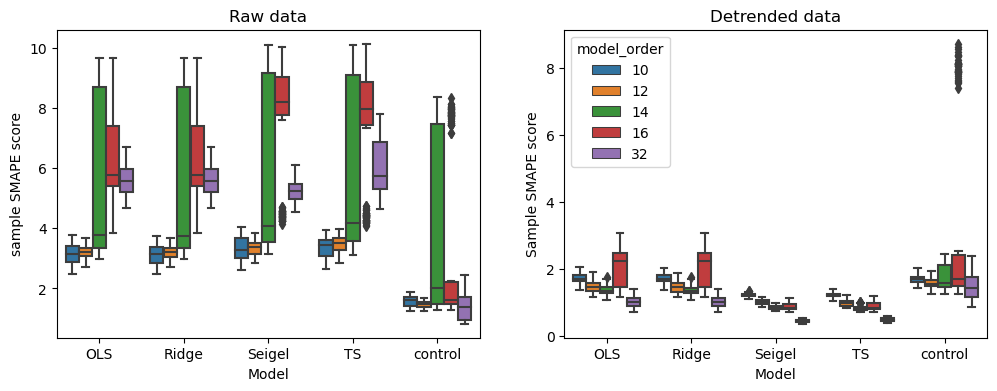

In [12]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)

ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample SMAPE score', 
    title='Detrended data'
)

plt.show()

Nice! So it looks like we might actually be beating our naive, 'carry-forward' control. Couple of observations here:
1. Fitting to the detrended data works best for the linear regression models over all.
2. All of the distributions have long-ish tails to high values.
3. The linear regression models with detrended data all benefit from a larger model order.
4. Seigel and Theil-Sen regression with detrended data look like the winners - with large model orders, both are getting the lowest mean sample SMAPE values and have the tightest spread of sample SMAPE values.
5. The control looks like it does a little bit better on the raw data than the detrended data.
6. The control seems like it may actually benefit slightly from a larger model order.

That last point seems a bit suspect, given the fact that the control is taking the last value from the input series as the forecast. It may be that those distributions are not really different and simply reflect between sample-of-samples variability. Let's move on for now, but keep it in mind.

Next take away is that I think we should be comparing the control with the raw data to the models with the detrended data. Doing so gives the control it's best shot and matches the setup used to produce our public leaderboard benchmark score of ~1.09.

Last thing to say for now is, let's focus on the detrended data and Siegel/Theil-Sen regression, with large model orders. Keep in mind that although both look to be doing better than the control over all - it's not by a wide margin and the spread of model and control sample SMAPE distributions are such that with some samples our regression models may loose to the control and vice versa.

Now, let's compare another way by plotting individual SMAPE values for all the datapoints for control vs regression.


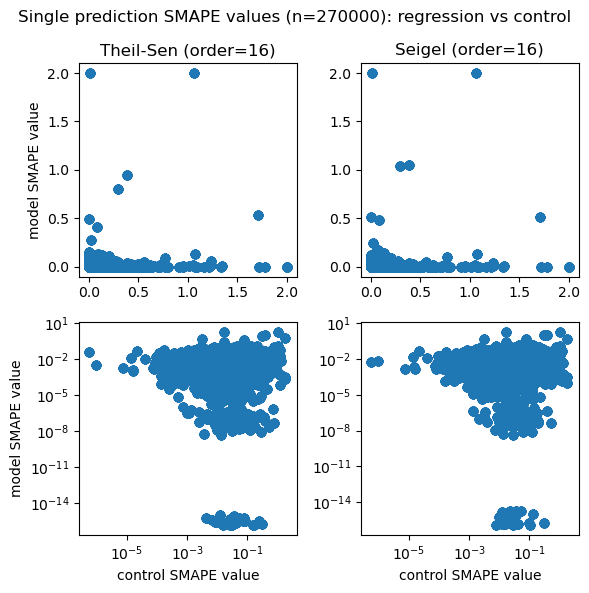

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

#ax[0,0].set_xlabel('control SMAPE value')
ax[0,0].set_ylabel('model SMAPE value')
ax[0,0].set_title('Theil-Sen (order=16)')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

#ax[0,1].set_xlabel('control SMAPE value')
#ax[0,1].set_ylabel('model SMAPE value')
ax[0,1].set_title('Seigel (order=16)')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('control SMAPE value')
ax[1,0].set_ylabel('model SMAPE value')
#ax[1,0].set_title('Theil-Sen (order=16)')

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('control SMAPE value')
#ax[1,1].set_ylabel('model SMAPE value')
#ax[1,1].set_title('Seigel (order=16)')

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

This plot is pretty cool - it shows the SMAPE score received by the control vs the regression models for each individual prediction across all of the samples. We can see that for both regression models, there are cases where the control gets a low score and the model gets a high score (upper left) and vice versa (lower right). In fact, it is interesting to note th 'L' shape of the point cloud. The shape indicates that datapoints which are predicted badly by one approach are predicted well by the other approach and this is especially true for the worst scored examples for each. This is a fascinating observation because it suggests an interesting idea - what if we used both the 'carry-forward' and a regression model as complementary approaches? Looking at the log-log plots, it appears to be a small fraction of the data, but all of the worst scoring points seem to follow the score complementarity rule described above. Neat.

Let's at least take a closer look at our winners.

In [14]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,OLS,10,3.128212,1.741408
1,OLS,12,3.209394,1.476624
2,OLS,14,5.061114,1.364646
3,OLS,16,6.420174,2.013564
4,OLS,32,5.611671,1.030668


In [15]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
30000,0,control,32,0.001937,0.017718,6.765365,6.872982,"[6.4812889, 6.2870626, 6.2824054, 6.3320813, 6...","[-0.04799750000000014, -0.1942263000000004, -0...",6.752276
30005,0,control,32,0.020725,0.027539,2.339813,2.355812,"[2.1368203, 2.1641047, 2.1800759, 2.1121981, 2...","[-0.003986599999999729, 0.027284400000000097, ...",2.291817
30010,0,control,32,0.012367,0.041540,2.208513,2.273905,"[1.7424223, 1.7286725, 1.7163248, 1.7076815, 1...","[-0.006165799999999999, -0.013749800000000034,...",2.181370


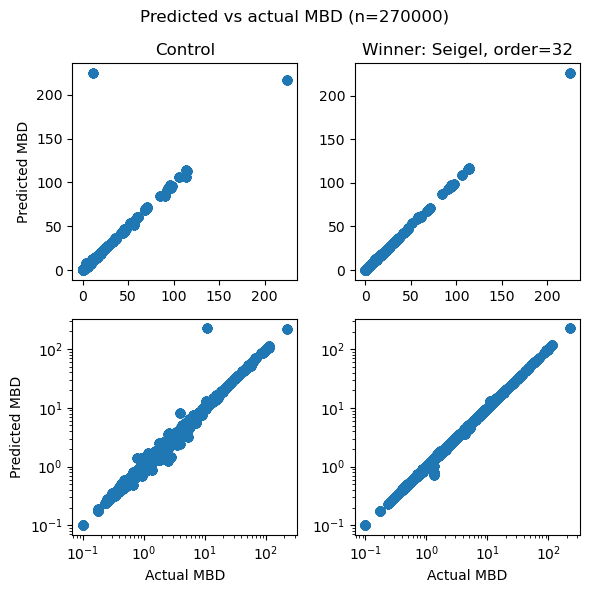

In [16]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

#ax[0,0].set_xlabel('Actual MBD')
ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')


ax[0,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

#ax[0,1].set_xlabel('Actual MBD')
#ax[1].set_ylabel('Predicted MBD')
ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')
#ax[1,0].set_title('Control')

ax[1,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')
#ax[1].set_ylabel('Predicted MBD')
#ax[1,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
#plt.setp(ax, xlim=(-10,250), ylim=(-10,250))
plt.tight_layout()

This looks VERY good, The winning model with the detrended data is straight as an arrow, even on a log-log plot, with very few exceptions. But, remember we are sampling - so we might have bad luck on the leaderboard.

As one more way to look at the control and winning score distributions, let's work up some basic summary stats with pandas describe

In [17]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['SMAPE_score'].describe()

count    180.000000
mean       1.525094
std        0.534515
min        0.825520
25%        0.955214
50%        1.395829
75%        1.718530
max        2.461331
Name: SMAPE_score, dtype: float64

In [27]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_SMAPE_score'].describe()

count    180.000000
mean       0.447275
std        0.034225
min        0.366105
25%        0.420803
50%        0.441195
75%        0.475397
max        0.534746
Name: detrended_SMAPE_score, dtype: float64

So, for context, the naive model gets ~1.1 on the public leaderboard. From our earlier bootstrapping experiments (see notebook #10), we determined that the probability of drawing a sample from the training dataset that scores as well or better with the naive control was about 1 in 4. The mean of the resampling distribution was ~1.9. In this experiment, we are seeing a mean of 1.5 and a standard deviation of 0.53 for the control. Looking at the percentiles, we see scores of ~0.95 at the 25<sup>th</sup> and 1.7 at the 75<sup>th</sup>. So again, our observed control leaderboard score is a pretty good showing for the naive model but, not crazy.

Our winning model has a mean of 0.45 and a 25<sup>th</sup> to 75<sup>th</sup> percentile range of 0.42 to 0.47. This makes it seem very likley that we will beat the naive control.

Last thing I want to do is run a quick test for difference of means and see if we can assign a significance level to it.

In [23]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_SMAPE_score'], control_sample_smape_scores['SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.2E}')

t-test p-value (H0: control mean = regression mean): 2.39E-88


In [20]:

import statsmodels.stats.api as sms

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.2f}, {ci[1]:.3f}')

95% C.I. around difference in means: -1.16, -0.999


Pretty much what I thought - the results suggest that the distributions actually are different.

Let's calculate the probability of drawing a score worse than the control public leaderboard result (1.094) from the regression model's resampling distribution.

In [25]:
import statistics
from statistics import NormalDist

smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Mean: {smape_mean:.3f}')
print(f'Standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Mean: 0.447
Standard deviation: 0.0341

Probability of SMAPE <= 1.0936: 1.000
Probability of SMAPE > 1.0936: 0.000


OK, never mind - it looks pretty likely that we will beat it!

I'v got two ideas here to give this thing a little boost:
1) Choose model order dynamically.
2) If the linear model is bad for a given data point, use the naive control value instead.

To do that we need some way to quantify how well the model is doing before we know the answer. Before we dig into it, let's just look and see if we have points where picking another model order would help and/or points where using the naive model would be better.

ValueError: x and y must be the same size

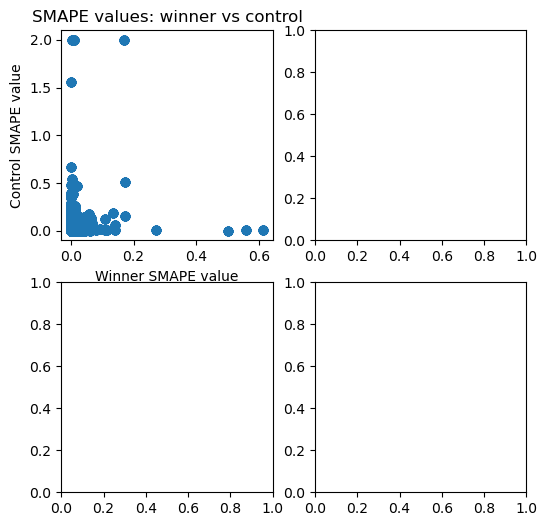

In [22]:
# Get raw data for winner
winner_order4 = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == 4.0)]
winner_order6 = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == 6.0)]
winner_order8 = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == 8.0)]

# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    winner['detrended_SMAPE_values'],
    control['detrended_SMAPE_values']
)
ax[0,0].set_xlabel('Winner SMAPE value')
ax[0,0].set_ylabel('Control SMAPE value')
ax[0,0].title.set_text('SMAPE values: winner vs control')

ax[0,1].scatter(
    winner['detrended_SMAPE_values'],
    winner_order4['detrended_SMAPE_values']
)
ax[0,1].set_xlabel(f'Winner, order = {winning_model_order}')
ax[0,1].set_ylabel(f'Winner, order = 4')
ax[0,1].title.set_text('Order 4 vs 10')

ax[1,0].scatter(
    winner['detrended_SMAPE_values'],
    winner_order6['detrended_SMAPE_values']
)
ax[1,0].set_xlabel(f'Winner, order = {winning_model_order}')
ax[1,0].set_ylabel(f'Winner, order = 6')
ax[1,0].title.set_text('Order 6 vs 10')

ax[1,1].scatter(
    winner['detrended_SMAPE_values'],
    winner_order8['detrended_SMAPE_values']
)
ax[1,1].set_xlabel(f'Winner, order = {winning_model_order}')
ax[1,1].set_ylabel(f'Winner, order = 8')
ax[1,1].title.set_text('Order 8 vs 10')

plt.suptitle('Predicted vs actual MBD\nwinning regression model and control')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

Yep - in each case, either the control or other model orders we have some extreme cases where our winner does badly and using the control value or a different model order would yield a better score. Let's try it - thing to do is recover the fit statistics and see if we can pick out points that are going to give high SMAPE values from the results of the fits alone.

It looks like the Theil-Sen regressor from SciPy returns the slope, intercept and also a confidence interval around the slope. We could use the width of the confidence interval as a handle for the 'goodness of fit'. But now that i'm thinking about it, it's not immediately obvious if we want 'good' fits or 'bad' fits. I could imagine it either way: a 'good' TS fit means a good TS prediction, or a bad TS fit means there is something funky going on where naive would actually do worse. Let's try plotting the MBD data for a few good TS results and a few bad TS results and see what it looks like.

In [ ]:
low_SMAPE = winner.sort_values(by='detrended_SMAPE_values')
low_SMAPE.head()

In [ ]:
high_SMAPE = winner.sort_values(by='detrended_SMAPE_values', ascending=False)
high_SMAPE.reset_index(inplace=True, drop=True)
high_SMAPE.head()

In [ ]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = high_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

In [ ]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = low_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Input data, low SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

In [ ]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = high_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Detrended input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

In [ ]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = low_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Detrended input data, low SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

OK, looking at the plots, I think it's pretty clear what is going on. If the MBD is changing too much, or has discontinuities or different change regimes in the time window, Theil-Sen does not do so well. In these cases it might be better to use a different model order or just pick the naive control value. So, I think either mean fit error or even the data range could be useful in spotting this. Let's make two more plots:
1. Data range vs SMAPE value
2. Fit residuals vs SMAPE value

And see if we can use either to make a reasonable threshold to detect 'bad' TS fits.

In [ ]:
import statistics

data_ranges = []
SMAPE_values = []
theil_slopes = []
total_fit_residuals = []
mean_fit_residuals = []
total_residuals_as_fraction_of_range = []
mean_residuals_as_fraction_of_range = []
slope_range = []
input_variance = []
input_deviation = []
input_absolute_sum = []

for i in range(len(winner)):

    # Get data for this row
    data_point = winner.iloc[[i]]
    input_data = list(data_point['detrended_MBD_inputs'])[0]
    SMAPE_value = list(data_point['detrended_SMAPE_values'])[0]
    data_range = max(input_data) - min(input_data)

    if data_range != 0:

        # Collect absolute input sum
        absolute_sum = 0
        
        for data in input_data:
            absolute_sum += abs(data)

        input_absolute_sum.append(absolute_sum)

        # Collect input variance
        input_variance.append(statistics.variance(input_data))

        # Collect input standard deviation
        input_deviation.append(statistics.stdev(input_data))

        # Collect input data range
        data_ranges.append(data_range)

        # Collect SMAPE value
        SMAPE_values.append(SMAPE_value)

        # Fit Theil-Sen
        ts = stats.theilslopes(input_data, list(range(len(input_data))))

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Collect slope
        theil_slopes.append(slope)

        # Collect slope range
        slope_range.append(ts[3] - ts[2])
        
        residuals = 0

        # Sum fit residuals
        for input in input_data:
            model_y = intercept + slope * input
            residuals += abs(model_y - input)

        total_fit_residuals.append(residuals)
        mean_fit_residuals.append(residuals / len(input_data))

        total_residuals_as_fraction_of_range.append(residuals / data_range)
        mean_residuals_as_fraction_of_range.append((residuals / len(input_data)) / data_range)
        

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(9,20))

ax[0].scatter(
    data_ranges,
    SMAPE_values
)
ax[0].set_xlabel('Input data range')
ax[0].set_ylabel('Detrended SMAPE value')
ax[0].title.set_text('SMAPE values vs input data range')

ax[1].scatter(
    total_fit_residuals,
    SMAPE_values
)
ax[1].set_xlabel(f'Total fit residuals')
ax[1].set_ylabel(f'Detrended SMAPE value')
ax[1].title.set_text('SMAPE values vs summed fit residuals')

ax[2].scatter(
    mean_fit_residuals,
    SMAPE_values
)
ax[2].set_xlabel(f'Mean fit residuals')
ax[2].set_ylabel(f'Detrended SMAPE value')
ax[2].title.set_text('SMAPE values vs mean fit residuals')

ax[3].scatter(
    total_residuals_as_fraction_of_range,
    SMAPE_values
)
ax[3].set_xlabel(f'Total fit residuals / input range')
ax[3].set_ylabel(f'Detrended SMAPE value')
ax[3].title.set_text('SMAPE values vs total fit residuals / input range')

ax[4].scatter(
    mean_residuals_as_fraction_of_range,
    SMAPE_values
)
ax[4].set_xlabel(f'Mean fit residuals / input range')
ax[4].set_ylabel(f'Detrended SMAPE value')
ax[4].title.set_text('SMAPE values vs mean fit residuals / input range')

ax[5].scatter(
    theil_slopes,
    SMAPE_values
)
ax[5].set_xlabel(f'Theil slope')
ax[5].set_ylabel(f'Detrended SMAPE value')
ax[5].title.set_text('SMAPE values vs Theil slope')

ax[6].scatter(
    slope_range,
    SMAPE_values
)
ax[6].set_xlabel(f'Theil slope range')
ax[6].set_ylabel(f'Detrended SMAPE value')
ax[6].title.set_text('SMAPE values vs Theil slope range')

ax[7].scatter(
    input_variance,
    SMAPE_values
)
ax[7].set_xlabel(f'Input variance')
ax[7].set_ylabel(f'Detrended SMAPE value')
ax[7].title.set_text('SMAPE values vs input variance')

ax[8].scatter(
    input_deviation,
    SMAPE_values
)
ax[8].set_xlabel(f'Input standard deviation')
ax[8].set_ylabel(f'Detrended SMAPE value')
ax[8].title.set_text('SMAPE values vs input standard deviation')

ax[9].scatter(
    input_absolute_sum,
    SMAPE_values
)
ax[9].set_xlabel(f'Input absolute sum')
ax[9].set_ylabel(f'Detrended SMAPE value')
ax[9].title.set_text('SMAPE values vs input absolute sum')

#plt.suptitle('Predicted vs actual MBD\nwinning regression model and control')
#plt.setp(ax, xlim=(-5,100), ylim=(-0.05,0.6))
plt.tight_layout()

OK, not making any progress. I think we need a different approach. Let's break this down further. I can imagine two (not necessarily mutually exclusive) scenarios which result in high SMAPE:
1. The next MBD value is crazy, so whatever fit the TS estimator came up with doesn't do a good job.
2. The input data is 'crazy' so the TS estimator does a bad job.

Maybe, let's take a closer look at the high smape data points and include the fit and the predicted and actual values. Hopefully, we can get a better idea of how and why the TS estimator is making bad predictions.

In [ ]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = high_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        MBD_actual = list(data_point['MBD_actual'])[0]
        last_input_MBD = list(data_point['MBD_inputs'])[0][-1]
        detrended_MBD_actual = MBD_actual - last_input_MBD
        x_values = list(range(len(MBD_values)))

        # Scatter plot the input data
        ax[i,j].scatter(
            x_values,
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        # Do the TS fit
        ts = stats.theilslopes(MBD_values, x_values)

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Plot fit + 1 additional point
        fit_values = []

        for x_value in list(range(len(x_values) + 2)):
            fit_values.append(intercept + slope * x_value)

        ax[i,j].plot(
            list(range(len(x_values) + 2)),
            fit_values
        )

        # Plot actual unknown value

        ax[i,j].scatter(
            len(x_values) + 1,
            detrended_MBD_actual
        )

        plot_num += 1

plt.suptitle('Detrended input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

In [ ]:
plot_rows = 4
plot_cols = 4
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(8,6))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = low_SMAPE.iloc[[plot_num]]
        MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        MBD_actual = list(data_point['MBD_actual'])[0]
        last_input_MBD = list(data_point['MBD_inputs'])[0][-1]
        detrended_MBD_actual = MBD_actual - last_input_MBD
        x_values = list(range(len(MBD_values)))

        # Scatter plot the input data
        ax[i,j].scatter(
            x_values,
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        # Do the TS fit
        ts = stats.theilslopes(MBD_values, x_values)

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Plot fit + 1 additional point
        fit_values = []

        for x_value in list(range(len(x_values) + 2)):
            fit_values.append(intercept + slope * x_value)

        ax[i,j].plot(
            list(range(len(x_values) + 2)),
            fit_values
        )

        # Plot actual unknown value

        ax[i,j].scatter(
            len(x_values) + 1,
            detrended_MBD_actual
        )

        plot_num += 1

plt.suptitle('Detrended input data, low SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

I still feel like the input range should work better than it does. I am starting to worry that we have a data gremlin or two kicking around. There is a lot going on in this notebook. That being said, maybe we are going about this wrong. Maybe we should fit each datapoint with multiple orders and then choose or weight the different predictions. Let's give this notebook a serious once over first to make sure everything is doing what we think it is doing.